In [1]:
import torch
import numpy as np
import random
from IPython.display import display

seed = 2021
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

!mkdir -p /kaggle/working/files

# Layer Abstract class

This class is the abstract class for all the layers in the neural network.

In [2]:
class Mode:
    TRAIN = 0
    INFERENCE = 1

class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        self.mode = Mode.TRAIN

    def forward(self, input):
        raise NotImplementedError

    def backward(self, output_grad):
        raise NotImplementedError

    def learnable_params(self):
        return None
    
    def set_mode(self, mode):
        self.mode = mode

# Dense Layer Class

Implementation of a fully connected layer that takes in an input and outputs a fully connected layer.

In [3]:
class DenseLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.zeros(output_size)
        self.input = None

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.biases

    def backward(self, output_grad):
        self.input_grad = np.dot(output_grad, self.weights.T)
        self.weights_grad = np.dot(self.input.T, output_grad)
        self.biases_grad = np.sum(output_grad, axis=0)
        return self.input_grad
    
    def learnable_params(self):
        return {'weights': self.weights, 'biases': self.biases}, {'weights': self.weights_grad, 'biases': self.biases_grad}

# Activation

Implementation of RelU, Sigmoid and SoftMax activation function and the Activation Layer

In [4]:
class ActivationFunction:
    def f(self, x):
        raise NotImplementedError

    def df(self, x):
        raise NotImplementedError


class ReLU(ActivationFunction):
    def f(self, x):
        return np.maximum(0, x)

    def df(self, x):
        return (x > 0).astype(int)


class Sigmoid(ActivationFunction):
    def f(self, x):
        return 1 / (1 + np.exp(-x))

    def df(self, x):
        return self.f(x) * (1 - self.f(x))


class SoftMax(ActivationFunction):
    def f(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def df(self, x):
        return self.f(x) * (1 - self.f(x))

In [5]:
class ActivationLayer(Layer):
    def __init__(self, activation_function):
        self.activation_function = activation_function
        self.input = None

    def forward(self, input):
        self.input = input
        return self.activation_function.f(input)

    def backward(self, output_grad):
        return output_grad * self.activation_function.df(self.input)

# Dropout Layer

Implementation of dropout layer. Dropout is a regularization technique that helps prevent overfitting by randomly setting some of the input units to zero during forward and backward passes.

In [6]:
class DropoutLayer(Layer):
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, input):
        if self.mode == Mode.TRAIN:
            self.mask = (np.random.rand(*input.shape) > self.dropout_rate) / (1 - self.dropout_rate)
            return input * self.mask
        return input
    
    def backward(self, output_grad):
        return output_grad * self.mask

# Batch Normalization layer

Implementations of batch normalization layer for normalizing the input to the neural network.

In [7]:
class BatchNormalizationLayer(Layer):
    def __init__(self, input_size, momentum=0.9, epsilon=1e-5):
        self.gamma = np.ones(input_size)
        self.beta = np.zeros(input_size)
        self.input = None
        self.momentum = momentum
        self.epsilon = epsilon
        self.running_mean = None
        self.running_var = None
        
    def forward(self, input):
        self.input = input
        if self.mode == Mode.TRAIN:
            mean = np.mean(input, axis=0)
            var = np.var(input, axis=0)
            if self.running_mean is None:
                self.running_mean = mean
                self.running_var = var
                
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
            
            # Cache these values for backward pass
            self.mean = mean
            self.var = var
            self.x_hat = (input - mean) / np.sqrt(var + self.epsilon)
            return self.gamma * self.x_hat + self.beta
        
        return self.gamma * (input - self.running_mean) / np.sqrt(self.running_var + self.epsilon) + self.beta
    
    def backward(self, output_grad):
        N = output_grad.shape[0]
        x_centered = self.input - self.mean
        std = np.sqrt(self.var + self.epsilon)

        # Gradients for gamma and beta
        self.beta_grad = np.sum(output_grad, axis=0)
        self.gamma_grad = np.sum(output_grad * self.x_hat, axis=0)
        
        # Gradient with respect to input
        dx_norm = output_grad * self.gamma
        dvar = np.sum(dx_norm * x_centered * -0.5 * std**(-3), axis=0)
        dmean = np.sum(dx_norm * -1/std, axis=0) + dvar * np.mean(-2 * x_centered, axis=0)
        
        input_grad = dx_norm / std + dvar * 2 * x_centered / N + dmean / N
        return input_grad
    
    def learnable_params(self):
        return {'gamma': self.gamma, 'beta': self.beta}, {'gamma': self.gamma_grad, 'beta': self.beta_grad}

# Optimizer

Implementations of optimizers for updating the weights and biases of the neural network.

In [8]:
class Optimizer:
    def __init__(self, lr):
        self.lr = lr

    def update(self):
        raise NotImplementedError

class SGD(Optimizer):
    def update(self, layer):
        weights_grad, biases_grad = layer.weights_grad, layer.biases_grad
        layer.weights -= self.lr * weights_grad
        layer.biases -= self.lr * biases_grad

class Adam(Optimizer):
    def __init__(self, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def update(self, layers):
        learnable_layers = [layer for layer in layers if layer.learnable_params() is not None]

        if self.m is None:
            self.m = [dict.fromkeys(layer.learnable_params()[0].keys(), 0) for layer in learnable_layers]
            self.v = [dict.fromkeys(layer.learnable_params()[0].keys(), 0) for layer in learnable_layers]

        self.t += 1
        for i, layer in enumerate(learnable_layers):
            params, grads = layer.learnable_params()
            for key in params.keys():
                self.m[i][key] = self.beta1 * self.m[i][key] + (1 - self.beta1) * grads[key]
                self.v[i][key] = self.beta2 * self.v[i][key] + (1 - self.beta2) * (grads[key] ** 2)
                m_hat = self.m[i][key] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i][key] / (1 - self.beta2 ** self.t)
                
                params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

# Loss Functions

Implementations of loss functions for evaluating the performance of the neural network.

In [9]:
class LossFunction:
    def f(self, y_true, y_pred):
        raise NotImplementedError

    def df(self, y_true, y_pred):
        raise NotImplementedError


class CrossEntropyLoss(LossFunction):
    def f(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred + 1e-8))

    def df(self, y_true, y_pred):
        return y_pred - y_true

# Neural Network

Implementation of a neural network with a variable number of layers and neurons.

In [10]:
class NeuralNetwork:
    def __init__(self, name, input_size, loss_function, optimizer):
        self.layers = []
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.name = name

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def set_mode(self, mode):
        for layer in self.layers:
            layer.set_mode(mode)

    def backward(self, output_grad):
        for layer in reversed(self.layers):
            output_grad = layer.backward(output_grad)

    def predict(self, input):
        return self.forward(input)

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import pandas as pd
import pickle

class Trainer:
    def __init__(self, train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader, model: NeuralNetwork, loss_function: LossFunction, optimizer: Optimizer, epochs: int, patience: int = 3):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.epochs = epochs
        self.train_df = pd.DataFrame(columns=['Epoch', 'Train_Loss', 'Train_Accuracy', 'Val_Loss', 'Val_Accuracy', 'Val_F1'])
        self.patience = patience
        self.early_stop = False
        self.best_val_loss = float('inf')
        self.no_improvement_epochs = 0

    
    def train(self):
        for epoch in tqdm(range(self.epochs)):
            if self.early_stop:
                break

            tr_loss, tr_acc = self.train_epoch()
            val_loss, val_acc, val_f1 = self.val_epoch()
            self.train_df.loc[epoch] = [epoch, tr_loss, tr_acc, val_loss, val_acc, val_f1]

            # Early stopping logic
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.no_improvement_epochs = 0
            else:
                self.no_improvement_epochs += 1
                if self.no_improvement_epochs >= self.patience:
                    print(f"Early stopping triggered after {self.patience} epochs without improvement.")
                    self.early_stop = True

        # Save the best model and training statistics
        self.model.set_mode(Mode.INFERENCE)
        with open(f'files/{self.model.name}_lr={self.optimizer.lr}_model.pkl', 'wb') as f:
            pickle.dump(self.model, f)
        self.train_df.to_csv(f'{self.model.name}_lr={self.optimizer.lr}_train_stats.csv', index=False)
        return self.train_df

    
    def train_epoch(self):
        self.model.set_mode(Mode.TRAIN)
        running_loss = 0.0
        all_y_true = []
        all_y_pred = []

        for X_b, y_b in self.train_loader:
            X_batch = X_b.numpy()
            y_batch = y_b.numpy()
            y_pred = self.model.forward(X_batch)

            loss = self.loss_function.f(y_batch, y_pred)
            running_loss += loss

            all_y_true.append(np.argmax(y_batch, axis=1))
            all_y_pred.append(np.argmax(y_pred, axis=1))

            grad = self.loss_function.df(y_batch, y_pred)
            self.model.backward(grad)
            self.optimizer.update(self.model.layers)

        all_y_true = np.concatenate(all_y_true)
        all_y_pred = np.concatenate(all_y_pred)

        epoch_loss = running_loss / len(self.train_loader)
        epoch_accuracy = accuracy_score(all_y_true, all_y_pred)

        return epoch_loss, epoch_accuracy
    

    def val_epoch(self):
        self.model.set_mode(Mode.INFERENCE)

        running_loss = 0.0
        all_y_true = []
        all_y_pred = []

        for X_b, y_b in self.val_loader:
            X_val = X_b.numpy()
            y_val = y_b.numpy()
            y_pred = self.model.forward(X_val)

            loss = self.loss_function.f(y_val, y_pred)
            running_loss += loss

            all_y_true.append(np.argmax(y_val, axis=1))
            all_y_pred.append(np.argmax(y_pred, axis=1))    

        all_y_true = np.concatenate(all_y_true)
        all_y_pred = np.concatenate(all_y_pred)

        epoch_loss = running_loss / len(self.val_loader)
        epoch_accuracy = accuracy_score(all_y_true, all_y_pred)
        epoch_f1 = f1_score(all_y_true, all_y_pred, average='macro')

        return epoch_loss, epoch_accuracy, epoch_f1


    def test(self, model_path = None):
        if not model_path: 
            model_path = f'files/{self.model.name}_lr={self.optimizer.lr}_model.pkl'

        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)

        self.model.set_mode(Mode.INFERENCE)
        all_y_true = []
        all_y_pred = []

        for X_test, y_test in self.test_loader:
            y_pred = self.model.forward(X_test)

            all_y_true.append(np.argmax(y_test, axis=1))
            all_y_pred.append(np.argmax(y_pred, axis=1))

        all_y_true = np.concatenate(all_y_true)
        all_y_pred = np.concatenate(all_y_pred)

        test_accuracy = accuracy_score(all_y_true, all_y_pred)
        test_f1 = f1_score(all_y_true, all_y_pred, average='macro')

        return test_accuracy, test_f1

    def plot(self):
        fig, ax = plt.subplots(1, 2)
        plt.figure(figsize=(10, 5))

        ax[0].plot(self.train_df['Train_Loss'], label='Train Loss')
        ax[0].plot(self.train_df['Val_Loss'], label='Val Loss')
        ax[1].plot(self.train_df['Train_Accuracy'], label='Train Accuracy')
        ax[1].plot(self.train_df['Val_Accuracy'], label='Val Accuracy')

        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()

        plt.savefig(f'files/{self.model.name}_lr={self.optimizer.lr}_train_plot.png')
        # plt.show()


    def confusion_matrix(self, dataloader):
        self.model.set_mode(Mode.INFERENCE)

        all_y_true = []
        all_y_pred = []

        for X, y in dataloader:
            y_pred = self.model.forward(X)

            all_y_true.append(np.argmax(y, axis=1))
            all_y_pred.append(np.argmax(y_pred, axis=1))

        all_y_true = np.concatenate(all_y_true)
        all_y_pred = np.concatenate(all_y_pred)

        # add fashionmnist labels
        labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        cm = confusion_matrix(all_y_true, all_y_pred)

        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')

        plt.savefig(f'files/{self.model.name}_lr={self.optimizer.lr}_confusion_matrix.png')
        # plt.show()

In [12]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

class FashionMNISTOneHot(datasets.FashionMNIST):
    def to_one_hot(self, target, num_classes=10):
        one_hot = np.zeros(num_classes, dtype=np.float32)
        one_hot[target] = 1
        return one_hot

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        target = self.to_one_hot(target)
        return img, target
        
train_dataset = FashionMNISTOneHot(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNISTOneHot(root='./data', train=False, download=True, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=2000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2000, shuffle=False)

# for X_batch, y_batch in train_loader:
#     print(X_batch.shape, y_batch.shape)
#     break

100%|██████████| 26421880/26421880 [00:02<00:00, 8825294.73it/s] 


Extracting ./data/FashionMNISTOneHot/raw/train-images-idx3-ubyte.gz to ./data/FashionMNISTOneHot/raw



100%|██████████| 29515/29515 [00:00<00:00, 137792.08it/s]


Extracting ./data/FashionMNISTOneHot/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNISTOneHot/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2552645.92it/s]


Extracting ./data/FashionMNISTOneHot/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNISTOneHot/raw



100%|██████████| 5148/5148 [00:00<00:00, 7656835.81it/s]

Extracting ./data/FashionMNISTOneHot/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNISTOneHot/raw



In [13]:
def get_model1(loss, optimizer):
    model1 = NeuralNetwork(name='model_1', input_size=784, loss_function=loss, optimizer=optimizer)

    model1.add_layer(DenseLayer(784, 256))
    model1.add_layer(ActivationLayer(ReLU()))
    model1.add_layer(DropoutLayer(0.5))
    model1.add_layer(BatchNormalizationLayer(256))

    model1.add_layer(DenseLayer(256, 10))
    model1.add_layer(ActivationLayer(SoftMax()))

    return model1

In [14]:
def get_model2(loss, optimizer):
    model2 = NeuralNetwork(name='model_2', input_size=784, loss_function=loss, optimizer=optimizer)

    model2.add_layer(DenseLayer(784, 1024))
    model2.add_layer(ActivationLayer(ReLU()))
    model2.add_layer(DropoutLayer(0.5))
    model2.add_layer(BatchNormalizationLayer(1024))

    model2.add_layer(DenseLayer(1024, 10))
    model2.add_layer(ActivationLayer(SoftMax()))

    return model2

In [15]:
def get_model3(loss, optimizer):
    model3 = NeuralNetwork(name='model_3', input_size=784, loss_function=loss, optimizer=optimizer)

    model3.add_layer(DenseLayer(784, 1024))
    model3.add_layer(ActivationLayer(ReLU()))
    model3.add_layer(DropoutLayer(0.5))
    model3.add_layer(BatchNormalizationLayer(1024))

    model3.add_layer(DenseLayer(1024, 1024))
    model3.add_layer(ActivationLayer(ReLU()))
    model3.add_layer(DropoutLayer(0.5))
    model3.add_layer(BatchNormalizationLayer(1024))

    model3.add_layer(DenseLayer(1024, 10))
    model3.add_layer(ActivationLayer(SoftMax()))

    return model3

model 1, lr 0.000625


 28%|██▊       | 28/100 [06:06<15:43, 13.10s/it]

Early stopping triggered after 5 epochs without improvement.


model 2, lr 0.000625


 26%|██▌       | 26/100 [09:24<26:46, 21.71s/it]

Early stopping triggered after 5 epochs without improvement.


model 3, lr 0.000625


 26%|██▌       | 26/100 [14:46<42:04, 34.11s/it]

Early stopping triggered after 5 epochs without improvement.


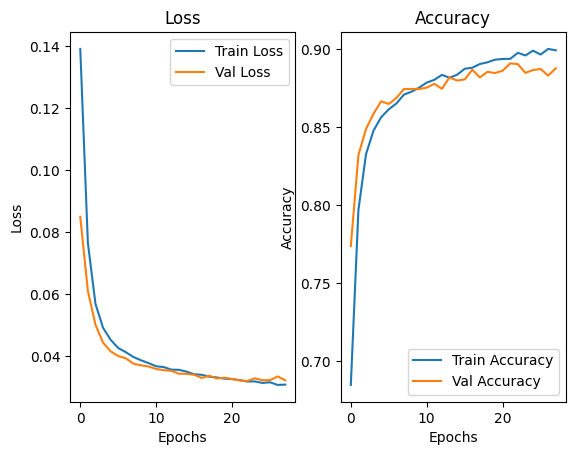

<Figure size 1000x500 with 0 Axes>

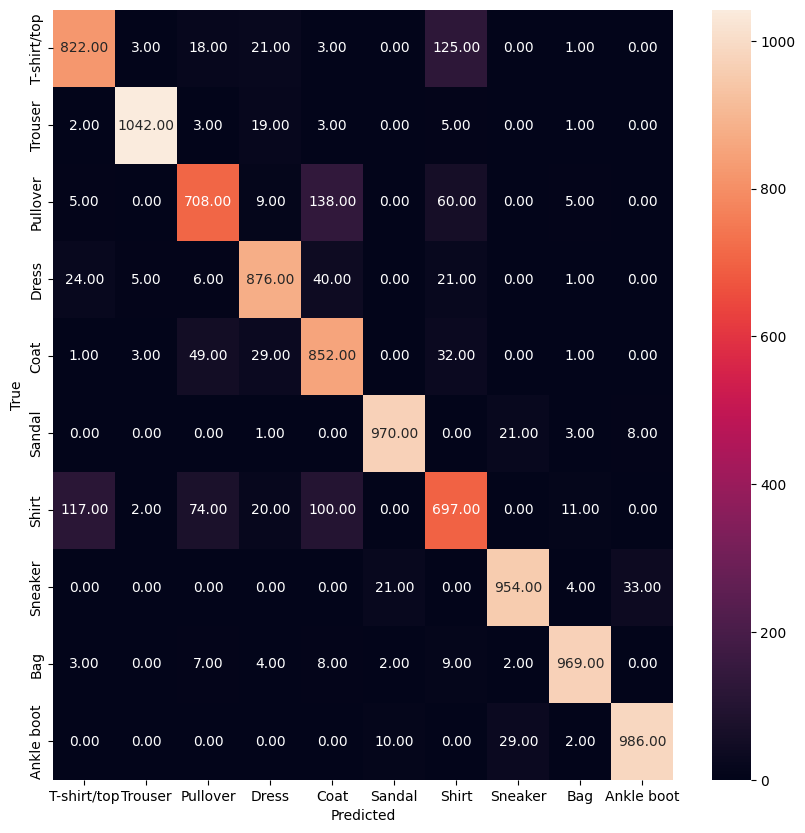

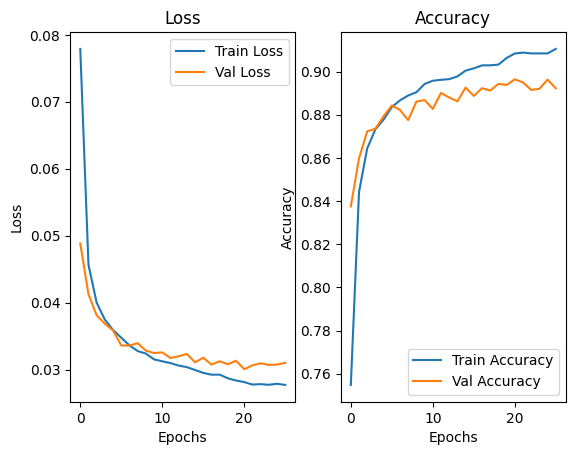

<Figure size 1000x500 with 0 Axes>

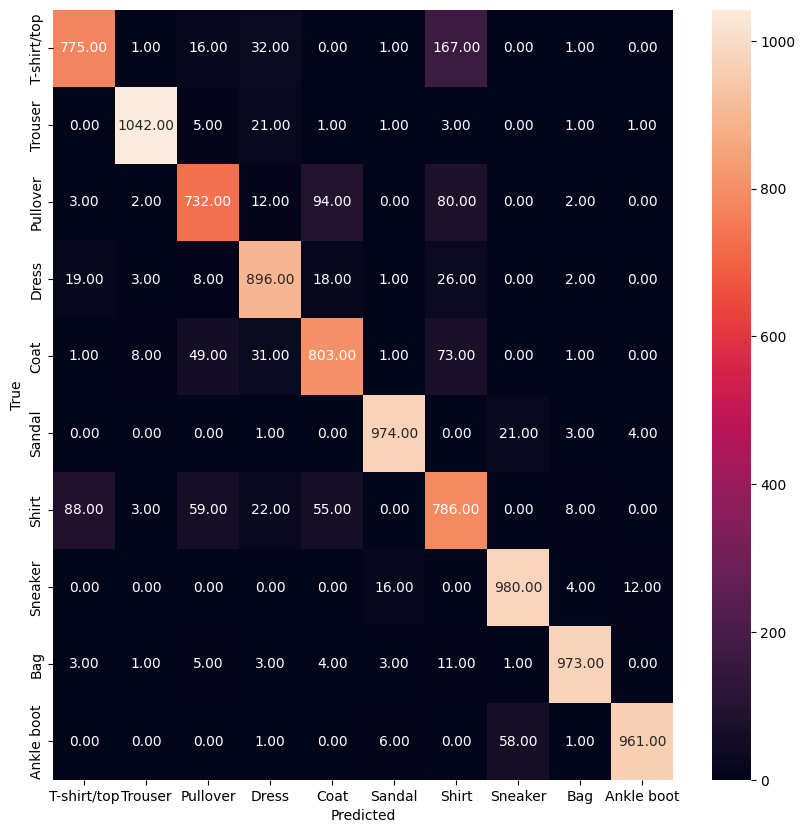

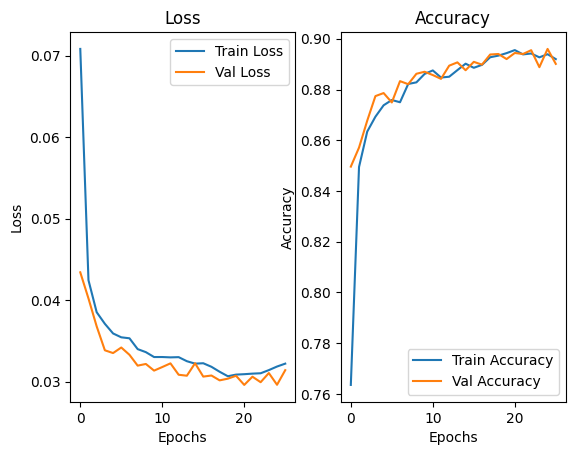

<Figure size 1000x500 with 0 Axes>

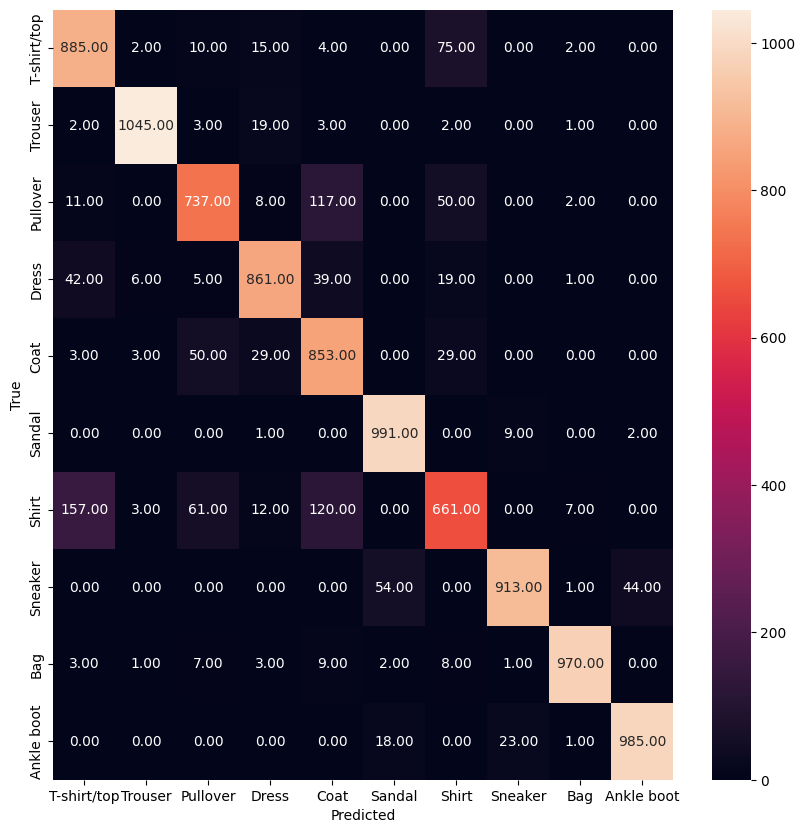

In [16]:
loss = CrossEntropyLoss()
base_lr = .005
epochs = 100
optimizer = Adam(lr=.005)
model_info = []

for i in range(3,4):
    for j in range(3):
        lr = base_lr * 2**(- i)
        optimizer = Adam(lr=lr)
        if j == 0: model = get_model1(loss, optimizer)
        elif j == 1: model = get_model2(loss, optimizer)
        else: model = get_model3(loss, optimizer)
            
        print(f"model {j+1}, lr {lr}")

        trainer = Trainer(train_loader, val_loader, test_loader, model, loss, optimizer, epochs, patience=5)
        train_df = trainer.train()

        # display(train_df)
        train_df.to_csv(f'{model.name}_lr={lr}_train_stats.csv', index=False)

        model_info.append({
            'model': model.name,
            'lr': lr,
            'val_f1': train_df['Val_F1'].max(),
            'epoch': train_df['Val_F1'].idxmax()
        })

        trainer.plot()
        trainer.confusion_matrix(val_loader)
    
    lr /= 2

In [17]:
# best_model = max(model_info, key=lambda x: x['val_f1'])
# print(f'Best Model: {best_model["model"]}, lr: {best_model["lr"]}, val_f1: {best_model["val_f1"]}, epoch: {best_model["epoch"]}')

model_path = f'/kaggle/input/best_model/other/default/1/model_3_lr=0.000625_model.pkl'
model = None

trainer = Trainer(train_loader, val_loader, test_loader, model, loss, optimizer, epochs=100)
test_accuracy, test_f1 = trainer.test()

print(f'Test Accuracy: {test_accuracy}')
print(f'Test F1: {test_f1}')

trainer.confusion_matrix(test_loader)

AttributeError: 'NoneType' object has no attribute 'name'